# Demo - Uncertain GP - Monte Carlo

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.mcmc import MCTransform

import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 60
ntest = 1_000
input_cov = 0.3

output_cov = 0.05
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

In [356]:
def real_f(x):
    return np.sin( 1.5 * x )

In [357]:
key = jax.random.PRNGKey(123)

X = np.linspace(-2., 2., 30)
Xtest = np.linspace(-2.1, 2.1, 1000)
y = real_f(X) + output_cov * jax.random.normal(key, (30,))
ytest = real_f(Xtest)

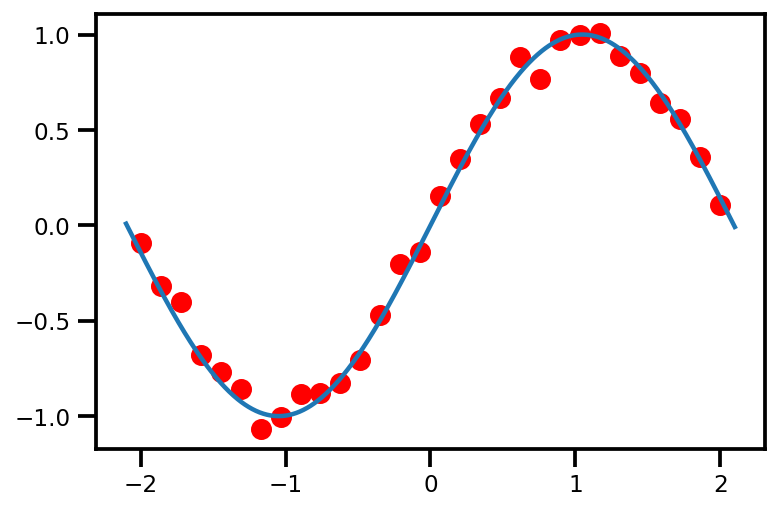

In [358]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [359]:
# initialize kernel
# kernel = RBF(length_scale=0.01, variance=1.0)
kernel = RationalQuadratic()

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RationalQuadratic).variance [1.]
(ExactGP).kernel(RationalQuadratic).length_scale [1.]
(ExactGP).kernel(RationalQuadratic).alpha [1.]
(ExactGP).noise [0.1]


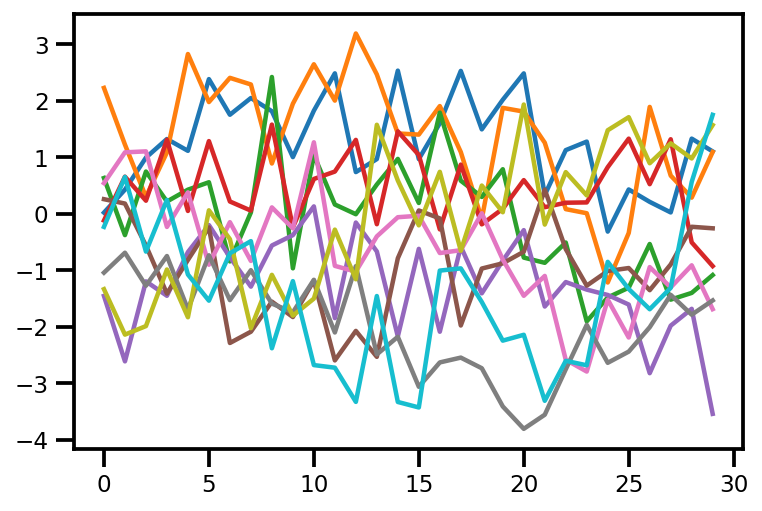

In [360]:
# generate random samples
model_dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = model_dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [361]:
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:02<00:00, 375.53it/s, Loss=-25.86]


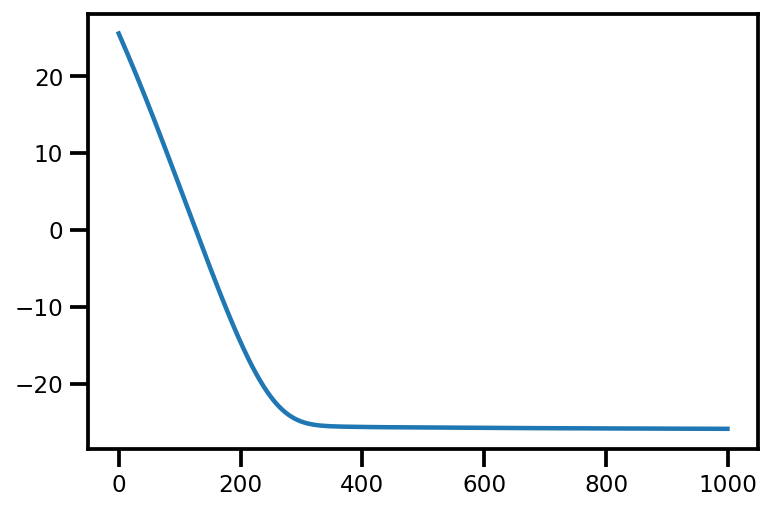

In [362]:
plt.plot(losses)

In [363]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RationalQuadratic).variance [1.273217] [1.520022] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).length_scale [1.105184] [1.3912271] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).alpha [8.719048] [8.719211] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-2.8532274] [0.05605697] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [364]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

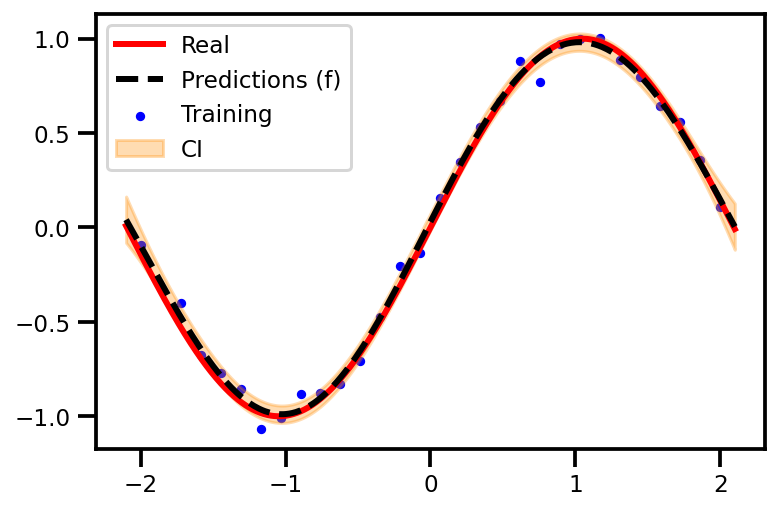

In [365]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [366]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

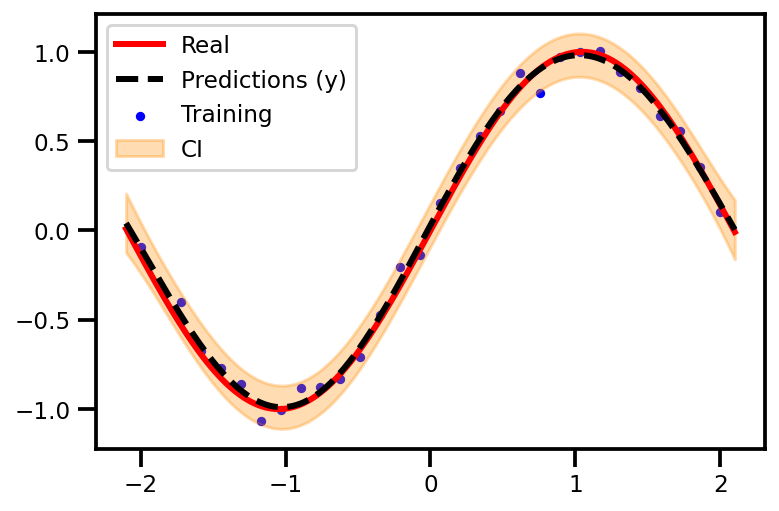

In [367]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Monte Carlo Sampling

In [368]:
from jaxkern.gp.uncertain.mcmc import get_mc_sigma_points
from jaxkern.gp.predictive import predictive_mean

In [369]:

mc_key, key = jax.random.split(key, 2)

n_mc_points = 10_000
sigma_pts  = get_mc_sigma_points(key, 1, (n_mc_points,))

f = jax.vmap(jax.partial(predictive_mean, model))

In [370]:
mu = f(Xtest)

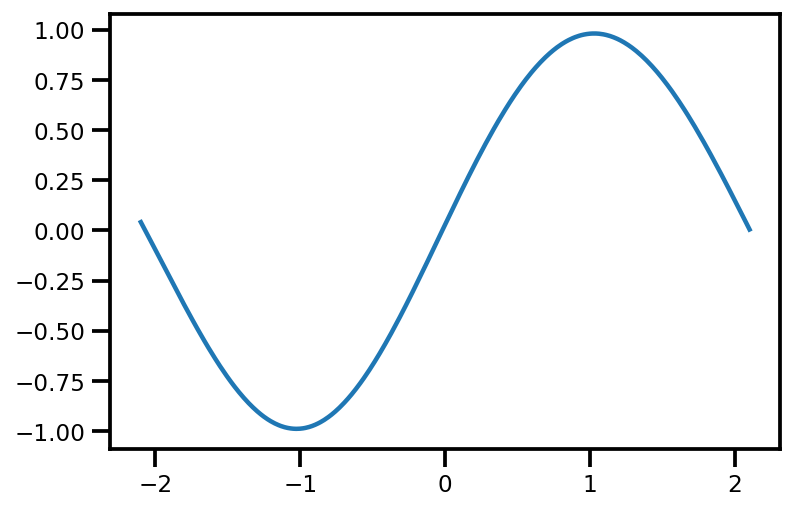

In [371]:
plt.plot(Xtest, mu)

In [372]:
x_sample = np.array([0.2]).reshape(-1, 1)
x_samples_cov = np.tile(np.diag(np.array([0.2])), (1, 1, 1))

x_mc_samples = x_samples + np.linalg.cholesky(x_samples_cov) @ sigma_pts.T

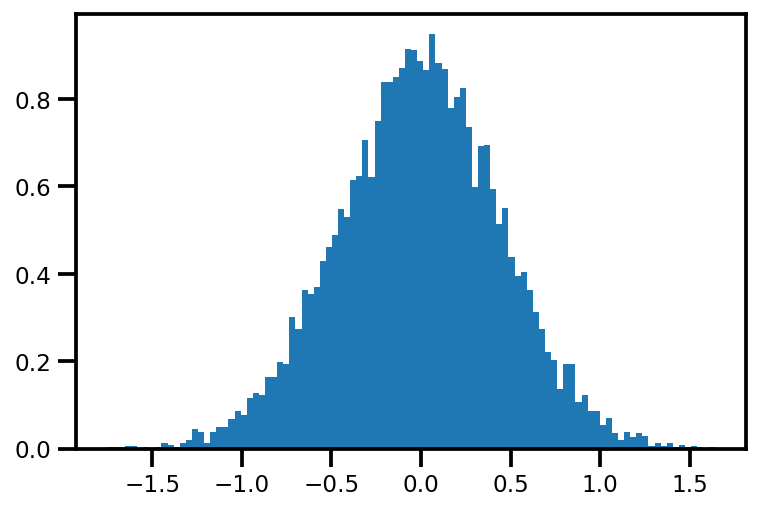

In [373]:
plt.hist(x_mc_samples.squeeze(), bins=100, density=True);

In [382]:
y_mc_samples = f(x_mc_samples.T) / n_mc_points

In [383]:
y_mc_samples.shape

(10000,)

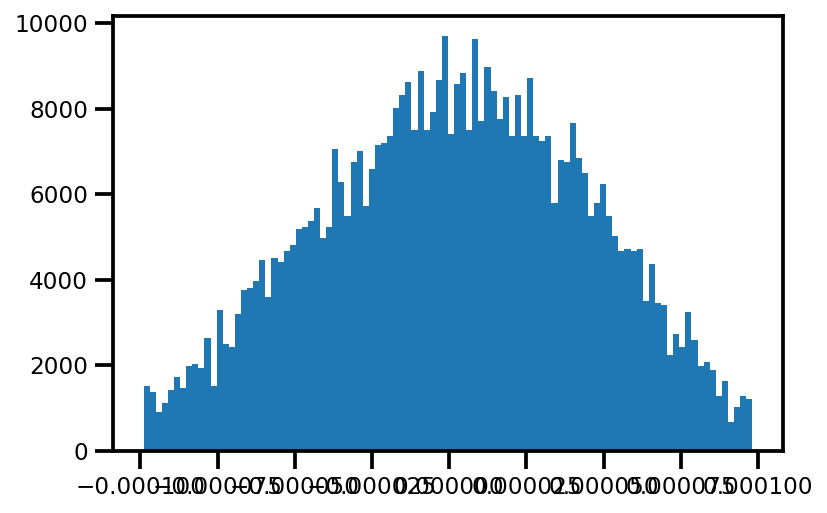

In [384]:
plt.hist(y_mc_samples.squeeze(), bins=100, density=True);

In [199]:
mc_transform = MCTransform(model, jitted=True)
n_mc_samples = 100

In [16]:
Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))
np.diag(np.array([input_cov])).shape

(1, 1)

In [20]:

x_sample.shape, x_samples_cov.shape

((1, 1), (1, 1, 1))

In [21]:
%%time

mean_f, var_f = mc_transform.forward(x_sample, x_samples_cov, n_mc_samples)

CPU times: user 817 ms, sys: 11.7 ms, total: 828 ms
Wall time: 826 ms


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.02045524, 0.12045524, 0.22045524, 0.32045525, 0.42045525,
        0.52045524, 0.62045527, 0.7204552 , 0.82045525, 0.9204552 ,
        1.0204552 ], dtype=float32),
 <BarContainer object of 10 artists>)

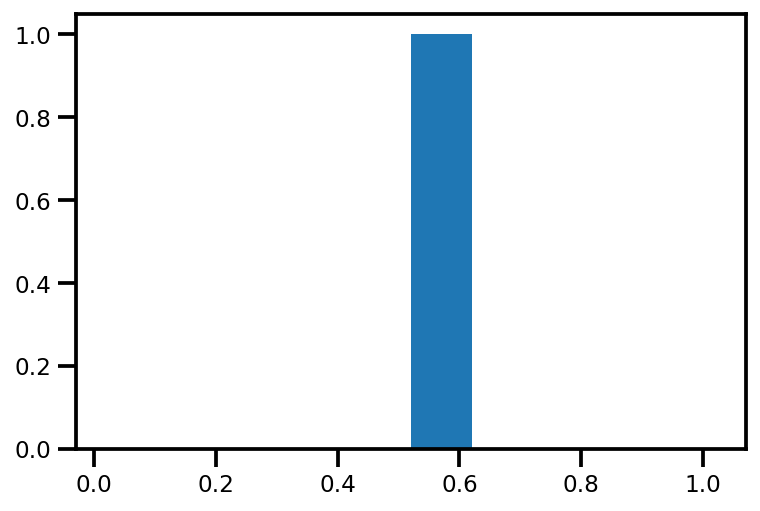

In [22]:
plt.hist(mean_f)

In [21]:
%%time

Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))
mean_f, var_f = mc_transform.forward(Xtest, Xtest_cov, n_mc_samples)

CPU times: user 260 ms, sys: 12.1 ms, total: 272 ms
Wall time: 262 ms


In [22]:
%%time

n_mc_samples = 1_000_000
mean_f, var_f = mc_transform.forward(Xtest, Xtest_cov, n_mc_samples)

CPU times: user 1.24 s, sys: 1.47 s, total: 2.71 s
Wall time: 724 ms


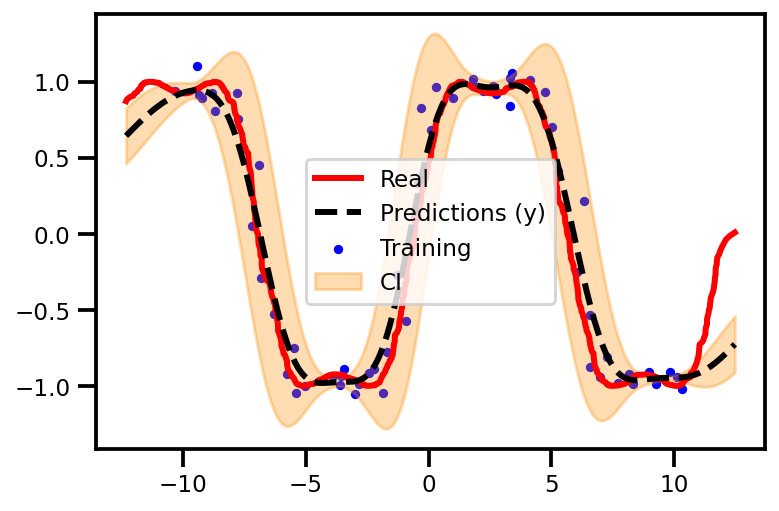

In [23]:
lb, ub = confidence_intervals(mean_f, var_f, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_f, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

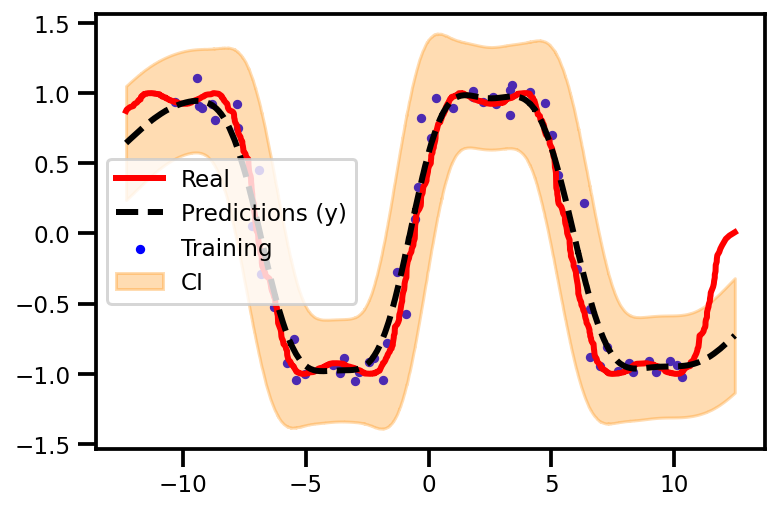

In [18]:
sigma = jax.nn.softplus(model.noise.value)

lb, ub = confidence_intervals(mean_f, var_f  + sigma ** 2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_f, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(),
    lb, ub, 
    label='CI', 
    color='darkorange', 
    alpha=0.3
)

plt.legend()

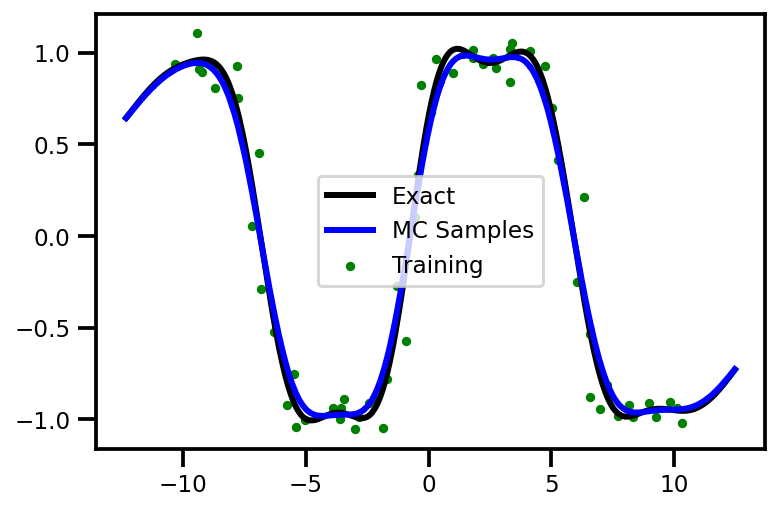

In [19]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_f, linestyle="-", label='MC Samples', color='blue', linewidth=3)
plt.legend()